In [1]:
include("../scripts/ideal_robot.jl")

In [18]:
using Distributions
using Random

In [2]:
mutable struct Robot <: AbstractRobot
    pose
    r
    color
    agent
    poses
    sensor
    noise_pdf
    distance_until_noise
    theta_noise
end

In [45]:
function Robot(pose, agent, sensor, color, noise_per_meter = 5, noise_std=pi/60)
    rbt = Robot(pose, 0.2, color, agent, [pose],  sensor, nothing, nothing, nothing)
    rbt.noise_pdf = Exponential(1.0/(1e-100 + noise_per_meter))
    rbt.distance_until_noise = rand(rbt.noise_pdf)
    rbt.theta_noise = Normal(0, noise_std)
    return rbt
end

Robot

In [50]:
function noise(self::Robot, pose, nu, omega, time_interval)
    self.distance_until_noise -= abs(nu)*time_interval + self.r*abs(omega)*time_interval
    if self.distance_until_noise <= 0.0
        self.distance_until_noise += rand(self.noise_pdf)
        pose[3] += rand(self.theta_noise)
    end
    return pose
end

noise (generic function with 1 method)

In [51]:
function one_step(self::Robot, time_interval)
    if isnothing(self.agent)
        return
    end
    obs = nothing
    if !isnothing(self.sensor)
        obs = data(self.sensor, self.pose)
    end
    nu, omega = decision(self.agent, obs)
    self.pose = state_transition(self, nu, omega, time_interval)
    self.pose = noise(self, self.pose, nu, omega, time_interval)
end

one_step (generic function with 3 methods)

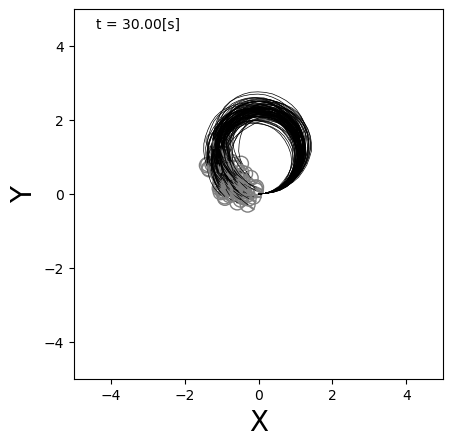

In [54]:
world = World(30, 1.0)
for i in 1:100
    circling = Agent(0.2, 10.0/180*pi)
    r = Robot([0.0,0.0,0.0], circling, nothing, "gray")
    append(world, r)
end
draw(world)

In [55]:
showanim("test.mp4")

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAjbBtZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTggLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAADNhliIQAF//+99S3zLLtU2+2C6j3op4mX0N1JQGblsTtOoAAAAMAAAMAAB68FzgCX4kK868AAAMAyoAXqEn/CmOPiA7BC5NJlvfhKIWPSXi/zA6JYDLoQAMQkginty7NGv2twoUk3+x++sOjYLO23GkLnX3zZEYn6a9vQcRQLf67K7SBvVrJ/o4DfjcfmL80ItpTpOBk9UoqIRYyXX9Jp26SG/qkhzXvDYJnUDUkXMWTV9xgIkId/B0DL63tzWtJoDT3qBLshsubVeON8CDX6ibsLgVVQ4A0D7tGbVkDzT/KsUAH7fA8ber7HvEJfThyzrLkSWNw9QjQzXk0jYHioNxDFOC0u5P/6flbarG27qxKpcR1g3jAe/uyNQkdibir9L1oZNoxCL9nTz5Do7WCxbfdwBz786P6Gt3+a9qFmQoe2Qlbs6zkxnOY8FmvubMXtnqJ20rtvpHrl79t6nq8q+9ZGR6BdRh00t3Aigy2K6jkGX8xF2NbE0107yMuMhNJ8nLf3bEUDA1W0TIui6TwnLCPxsZoeNH9a4AHuu+fRe2d9XIIXx50n+Od5FnEb6C9gPt3e826oHE1AgcXxvRCBxQI/BeMobygLn0j9VWXolTLRr1nefL0lQJDHRd0bMQ2bwJ+rzm8Mp/b24dtpJKsQryCKzCJcKad8rXWcKOAUajWn2P0NKgXGBFwI0M+idp/QrLQJJggEup5GqdX9LpivTz0Tg/GtPHRN/r0yThMt621zn7a4ylSl42LRaw5MezwM/+4GZwzEqm3AEN61OX4+ROEd9aArigTp3XWPCo1M3arBFgwglcnHb1e8ZbqIj4YaLbonxrArOWHmfSfBqXWPde/WRktmyHhQ5zaphFSjYU0Lns11vXjU1ONMVKVbNEfaKST3u+nzCLmQVjsoOK4fNxLvubsCygriI+/cKxxNVwhwMxig92FhVnxjeW0Qawhd7VT1zV28fRz3/DtwAEYAEMPhuaPHs+eUmorS8OmkrKb/BFyL/+uIgBi9KTpelcn4ZADCZ5v4oynHm5NxE59pKbJ9JAsOPBdsd2kCu71nJq/EQYHSrbPdz4PH+mJYSEYOMqie4UU1lgO5wDyZhNdlPulQzeofOFm1zv7YjSTVXgnqxotN06/hxHfEupEYr4JwU4Vxzm/7S98Zg8N9S7JPyWDhPU3xZQklMgfm/wYdLHCTtRfKP7SjJinBdxNxmZ5Lsj4iGTzD1ATeh9md4XleyTPJcEX42UJYIBb/3FzS4TBMUhQXPKIE3INAIYSVT7KNKE5Nno/rPZFicYk/zri4vwMWbxNc45aAjX4CQNCsesTDLDrqz/seeQH5nRKybNvVqeFP6/tciMZvNsVAMu9MFSz9IqHRoh6W+vIC3Uplbh1KeEe9BPSvlahWUDsuQdaLzbo1Dr4d+hLejubyxoZ5VGaioPBBaYce+dASRA2lvgJIKIblQ9u8rSSllrXRQLzu8vfmhPDiw1ceBWBgDOXooHs2WtpICElmnqPeOvyHHlNGNwgvNNz6jXq0qn+yQMfoh/EWI/8EXHQ72h2WSyrDdkcq/2D8qVpeamBwXGOIkbDmscFhDDxpgjdR17Guw/XI4W2pigJkqqltej87340eyYGSKM+OtLZTVeesLET5Mg3v2YeaO0+8fIoyUdhn1jhIYI2ZOSYArY6R0h8DEAFq8/Jv2OaQhMGtUcobfd6VGvszZF6DvAlg7tHK7acbrtn97Rj9oYt2SxDAeGW9Lzbto6fH3JbXrNqqPepvo/d2+mfgW4jmX1A4hi/kg2yGN7+SvydgO8w/+Ex5Uo9cb6Wy2m9t9zwYS7SkenCLuArIVFC5W9JL4XsaucYw1ERPeXHyOYWfNadjlJB7ollvx0mNVtBLaNXzXYmvAwyewJTOcl2qGUa14uui1AMnU5hQQpLWIaguJ4IoxXQTFoe5Xv47zS/tanfRAin/cSGxSGggMiTtApM0pyfJwTk3DKC7Vzv//Rr4zO3CrmzV5zjXWOYO1Lt/TXaJLJeoSpZDUcTQY/cguJ6ZuUubdYhCo1E1ZLiKh9A2QaisCW+JltgOhGMPQ8y1VQlXvV64QGK0EWnttT6wjc3PJLrSYHg6/xSDTebW/1UoONF+0h2cY1nLrl8ojkv86Ft1wwCXuOUegUpjhXQH09h8a0bseM56Ob4ax6z06EolQTQSXqz0rdMCp07tBWAKcStAUcrvTNmAiK5X/+PJFlJ1JNK0bf+J3YnfjbAIvNFvpnbw1/A30feHY31w5wteWhCRdTnktxhXmAwmavlqqAgMPhaGngfr/Jf0AAAAwAAFYXrg0oRYNvtX2jOwxVkSdfLgMxtLn9t9stv0MvCcySgTeaDiEUY4VuzTxUBNue4SdlDb1hVBluO8yvTG2lInrWmEalin+EiwBZ950l+4ydEyVoUxpKkLGgEYsSBqZxTDfL5SrDBOnOCpaQbIHRSve/60fiUTevJ4LC2w1JM6ReWu4kLw0xsYHR/9/85dabOUd78jri8XcB8xizZ3EAKYkoEQo6O/ATc+UGcluZCK4no56oOK0MVQII550sPLvOsQ3B5h94w+irVwAAAAwADOor81mbZfkdVsXSolnS3a48rDd3NrB2QiQSpaRAorBiFntUt/RPo1864Z+CF1bzw9Razphgt/DZGJd4q6syGsw9fdagHZzhdReGqTDThYJWu9mrgI3+uOA6Fq6UM6FofV6ki+VnBOiCj+i8MnSrG9B/sn+MPKwduSLc+1fqtHriJbClQAwLcFAjVhhZCQFZkOZbxu8evFvghaWroT8V91+zCtR5TocRXCLwahH8f7lDAZ6e3OAAP6crU4WYpq+YgTyhrHDbFlISAa9dgy14nqUZ2pTvcTvrmbAKP//zmbmr7ANtR5td5V0oUKqQny3Dq9A4kuYML78APzPCCHfathiHoOrAdnxsKfPxR99XF0Id9KMPHokBCO+xMdzQKx91hzEt6A2P2G60GSDpoZxP